<a href="https://colab.research.google.com/github/seanreed1111/colab-demos/blob/master/pareto_nbd_original_numpyro_informative_priors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

see also: 
- https://www.briancallander.com/posts/customer_lifetime_value/recency_frequency.html
- https://github.com/mplatzer/BTYDplus/blob/master/R/pareto-nbd-mcmc.R
- https://github.com/mplatzer/BTYDplus



In [1]:
# installlation required
!pip install -q numpyro lifetimes


     |████████████████████████████████| 283 kB 15.5 MB/s 
     |████████████████████████████████| 584 kB 45.3 MB/s 


<a id = "7"></a><br>
# LIBRARIES

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('precision', 2)

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import logging
from scipy.stats import expon

from jax import numpy as jnp
from jax import jit, random
import jax

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')
plt.rcParams['figure.figsize'] = [8, 4]

logging.basicConfig(level=logging.WARN)

In [3]:
def make_tables(*,
                   n=100,
                   start_period = 0.,
                   forecast_period_end = 120.,
                   mean_customer_lifetime = 80.,
                   mean_period_between_purchases = 10.
                   ):


  assert start_period < forecast_period_end
  assert mean_customer_lifetime > 0. and mean_period_between_purchases > 0.

  transaction_table = np.zeros((1,3))
  rf_table = np.zeros((1,5)) # customer id, date of first transaction, date of last transaction, purchases, date last observed

  for id in range(n):
    tau = expon.rvs(scale=mean_customer_lifetime) # true (latent) lifetime
    t, k = start_period, 0 
    wait = expon.rvs(scale=mean_period_between_purchases) # waiting time between purchases
    purchase_time= []
    purchase_number = [] #arrays will contain all transactions done by customer

    while ((t + wait) < min(forecast_period_end, start_period + tau)): 
      t += wait
      k += 1
      wait = expon.rvs(scale=mean_period_between_purchases)
      purchase_time.append(t)
      purchase_number.append(k)

    last_transaction_date = t    

    if k==0:
      first_transaction_date = 0
      last_transaction_date = 0
    elif k==1: 
      first_transaction_date = t
    else:
      first_transaction_date = purchase_time[0]
    
    # customer id, date of first transaction, date of last transaction, purchases, date last observed
    rf_table = np.append(rf_table, np.array([id,k,first_transaction_date,last_transaction_date, forecast_period_end]).reshape(-1,5), axis=0)
    transaction_table = np.append(transaction_table, (np.stack((id*np.ones(k), np.array(purchase_number), np.array(purchase_time)), axis=1)), axis=0)

  return transaction_table[1:], rf_table[1:] #ditch the unneeded rows of zeros



In [4]:
def make_dfs(n=100):
  transaction_table, rf_table = make_tables(n=n)
  df = pd.DataFrame(rf_table, columns=['id','purchases','first_purchase_date','last_purchase_date', 'period_end'])
  df.loc[:,'elapsed_time_since_first_purchase'] = df['period_end'] - df['first_purchase_date']
  df.loc[:,'elapsed_time_since_last_purchase'] = df['period_end'] - df['last_purchase_date']
  df.loc[:,'avg_purchase_rate_1'] = df['purchases']/(df['last_purchase_date'] - df['first_purchase_date'])
  df.loc[:,'avg_purchase_rate_2'] = df['purchases']/df['elapsed_time_since_first_purchase']
  df.loc[:,'avg_days_between_purchases_low'] = 1./df['avg_purchase_rate_1']
  df.loc[:,'avg_days_between_purchases_high'] = 1./df['avg_purchase_rate_2']
  df.loc[:, 'repeat_purchases'] = np.where(df['purchases'] >1, df['purchases'] - 1, 0)
  return pd.DataFrame(transaction_table, columns=['id','purchase_number','purchase_date']), df

In [5]:
df_transactions, df = make_dfs(n=150)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,150.0,74.50,43.45,0.00,37.25,74.50,111.75,149.00
purchases,150.0,5.93,4.66,0.00,2.00,6.00,9.75,18.00
first_purchase_date,150.0,7.51,8.06,0.00,1.27,4.80,11.73,39.74
last_purchase_date,150.0,49.45,40.97,0.00,13.32,36.89,88.54,119.83
period_end,150.0,120.00,0.00,120.00,120.00,120.00,120.00,120.00
elapsed_time_since_first_purchase,150.0,112.49,8.06,80.26,108.27,115.20,118.73,120.00
elapsed_time_since_last_purchase,150.0,70.55,40.97,0.17,31.46,83.11,106.68,120.00
avg_purchase_rate_1,131.0,inf,NaN,0.06,0.12,0.17,0.29,inf
avg_purchase_rate_2,150.0,0.05,0.04,0.00,0.02,0.05,0.09,0.19
avg_days_between_purchases_low,131.0,5.94,3.67,0.00,3.50,6.05,8.54,17.45


In [6]:
data = df[df['repeat_purchases'] >= 1.].copy() #only repeat customers
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,115.0,76.74,42.62,1.00e+00,42.50,78.00,113.50,149.00
purchases,115.0,7.60,4.03,2.00e+00,4.00,7.00,10.00,18.00
first_purchase_date,115.0,8.56,8.11,2.21e-02,2.81,5.77,12.24,39.74
last_purchase_date,115.0,63.25,36.81,1.31e+00,30.82,61.55,97.45,119.83
period_end,115.0,120.00,0.00,1.20e+02,120.00,120.00,120.00,120.00
elapsed_time_since_first_purchase,115.0,111.44,8.11,8.03e+01,107.76,114.23,117.19,119.98
elapsed_time_since_last_purchase,115.0,56.75,36.81,1.69e-01,22.55,58.45,89.18,118.69
avg_purchase_rate_1,115.0,1.25,10.14,5.73e-02,0.11,0.15,0.21,108.14
avg_purchase_rate_2,115.0,0.07,0.04,1.67e-02,0.04,0.06,0.09,0.19
avg_days_between_purchases_low,115.0,6.76,3.12,9.25e-03,4.75,6.46,8.83,17.45


In [7]:
pd.set_option('display.max_rows', 100)
data.reset_index()

,index,id,purchases,first_purchase_date,last_purchase_date,period_end,elapsed_time_since_first_purchase,elapsed_time_since_last_purchase,avg_purchase_rate_1,avg_purchase_rate_2,avg_days_between_purchases_low,avg_days_between_purchases_high,repeat_purchases
0,1,1.0,13.0,24.59,86.20,120.0,95.41,33.80,0.21,0.14,4.74e+00,7.34,12.0
1,3,3.0,7.0,12.36,86.90,120.0,107.64,33.10,0.09,0.07,1.06e+01,15.38,6.0
2,4,4.0,2.0,15.41,15.43,120.0,104.59,104.57,108.14,0.02,9.25e-03,52.30,1.0
3,5,5.0,11.0,0.65,110.68,120.0,119.35,9.32,0.10,0.09,1.00e+01,10.85,10.0
4,6,6.0,8.0,8.08,96.26,120.0,111.92,23.74,0.09,0.07,1.10e+01,13.99,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,143,143.0,12.0,0.36,107.14,120.0,119.64,12.86,0.11,0.10,8.90e+00,9.97,11.0
111,145,145.0,10.0,9.00,96.29,120.0,111.00,23.71,0.11,0.09,8.73e+00,11.10,9.0
112,147,147.0,11.0,18.07,110.52,120.0,101.93,9.48,0.12,0.11,8.40e+00,9.27,10.0
113,148,148.0,15.0,7.66,113.85,120.0,112.34,6.15,0.14,0.13,7.08e+00,7.49,14.0


In [8]:
t, T, x = jnp.array(data['last_purchase_date'].values), jnp.array(data['elapsed_time_since_first_purchase'].values), jnp.array(data['repeat_purchases'].values) #to conform to BTYD notation
inputs = {'t':t, 'T':T, 'x':x}

In [9]:
df_transactions

,id,purchase_number,purchase_date
0,0.0,1.0,7.73
1,1.0,1.0,24.59
2,1.0,2.0,24.82
3,1.0,3.0,24.86
4,1.0,4.0,25.95
...,...,...,...
885,149.0,5.0,50.13
886,149.0,6.0,53.79
887,149.0,7.0,56.82
888,149.0,8.0,60.21


In [19]:
@jit
def loglik(Lambda, mu, t, T, x):
  target = x * jnp.log(Lambda) - jnp.log(Lambda + mu)
  n = t.size
  for i in range(n):
    target  = target + jnp.logaddexp(jnp.log(Lambda[i]) - (Lambda[i] + mu[i]) * T[i],
                                      jnp.log(mu[i]) - (Lambda[i] + mu[i]) * t[i]
                                      )
  return target

In [20]:
def model(*, t, T, x, prior_only=True):
  '''
  input:
  vector t (nx1)  = 
  vector T (nx1) = 
  vector x (nx1) = number of ADDITIONAL purchases observed (x must be >= 1)

  '''

  
  inv_lambda_mean = jnp.log(10.)   # 0.1 purchases per period. (i.e., mean period between purchases = 10)
  sigma_beta_inv_lambda = jnp.log(3.)
  beta_inv_lambda = numpyro.sample('beta__inv_lambda', dist.StudentT(10., inv_lambda_mean, sigma_beta_inv_lambda))
  sigma_inv_lambda = numpyro.sample('sigma_inv_lambda', dist.Exponential(1.))

  etau_mean = jnp.log(80.) #ie. mean lifetime = 80 days
  sigma_beta_etau = jnp.log(9.)
  beta_etau = numpyro.sample('beta_etau', dist.Normal(etau_mean, sigma_beta_etau))
  sigma_etau = numpyro.sample('sigma_etau', dist.Exponential(1.))

  if not prior_only:
    with numpyro.plate("data", t.size):
      alpha_lambda = numpyro.sample('alpha_lambda', dist.Normal(0.,1.))
      inv_lambda = numpyro.deterministic('inv_lambda',jnp.exp(beta_inv_lambda + sigma_inv_lambda*alpha_lambda))

      alpha_etau = numpyro.sample('alpha_etau', dist.Normal(0.,1.))
      etau = numpyro.deterministic('etau',jnp.exp(beta_etau + sigma_etau*alpha_etau))

      mu = numpyro.deterministic('mu', 1./etau)
      lambda_ = numpyro.deterministic('lambda', 1./inv_lambda)
      return numpyro.factor('loglik', loglik(lambda_, mu, t, T, x))


In [15]:
# def model2(*, t, T, x, prior_only=True):
#   '''
#   input:
#   vector t (nx1)  = 
#   vector T (nx1) = 
#   vector x (nx1) = number of ADDITIONAL purchases observed (x must be >= 1)

#   '''

  
#   lambda_mean = jnp.log(0.1) # 0.1 purchases per period. (i.e., mean period between purchases = 10)
#   sigma_beta_lambda = 0.3
#   beta_lambda = numpyro.sample('beta_lambda', dist.Normal(lambda_mean, sigma_beta_lambda))
#   sigma_lambda = numpyro.sample('sigma_lambda', dist.Exponential(1.))
#   etau_mean = jnp.log(80) #ie. mean lifetime = 80 days
#   sigma_beta_etau = jnp.log(10)
#   beta_etau = numpyro.sample('beta_etau', dist.Normal(etau_mean, sigma_beta_etau))
#   sigma_etau = numpyro.sample('sigma_etau', dist.Exponential(1.))

#   if not prior_only:
#     with numpyro.plate("data", t.size):
#       alpha_lambda = numpyro.sample('alpha_lambda', dist.Normal(0.,1.))
#       lambda_ = numpyro.deterministic('lambda',jnp.exp(beta_lambda + sigma_lambda*jnp.log(alpha_lambda)))
#       alpha_etau = numpyro.sample('alpha_etau', dist.Normal(0.,1.))
#       etau = numpyro.deterministic('etau',jnp.exp(beta_etau + sigma_etau*jnp.log(alpha_etau)))
#       mu = numpyro.deterministic('mu', 1./etau)
#       numpyro.factor('loglik', loglik(lambda_, mu, t, T, x))


In [21]:
model = model
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=250, num_samples=300, num_chains=1)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, prior_only=True, **inputs)
mcmc.print_summary(exclude_deterministic=False)

sample: 100%|██████████| 550/550 [00:04<00:00, 117.46it/s, 7 steps of size 4.39e-01. acc. prob=0.91]



                        mean       std    median      5.0%     95.0%     n_eff     r_hat
  beta__inv_lambda      2.43      1.16      2.41      0.39      4.13    246.89      1.00
         beta_etau      4.66      2.20      4.64      1.10      8.11    211.98      1.00
        sigma_etau      1.04      1.09      0.73      0.00      2.45    317.36      1.00
  sigma_inv_lambda      1.05      0.91      0.79      0.00      2.19    422.08      1.00

Number of divergences: 0


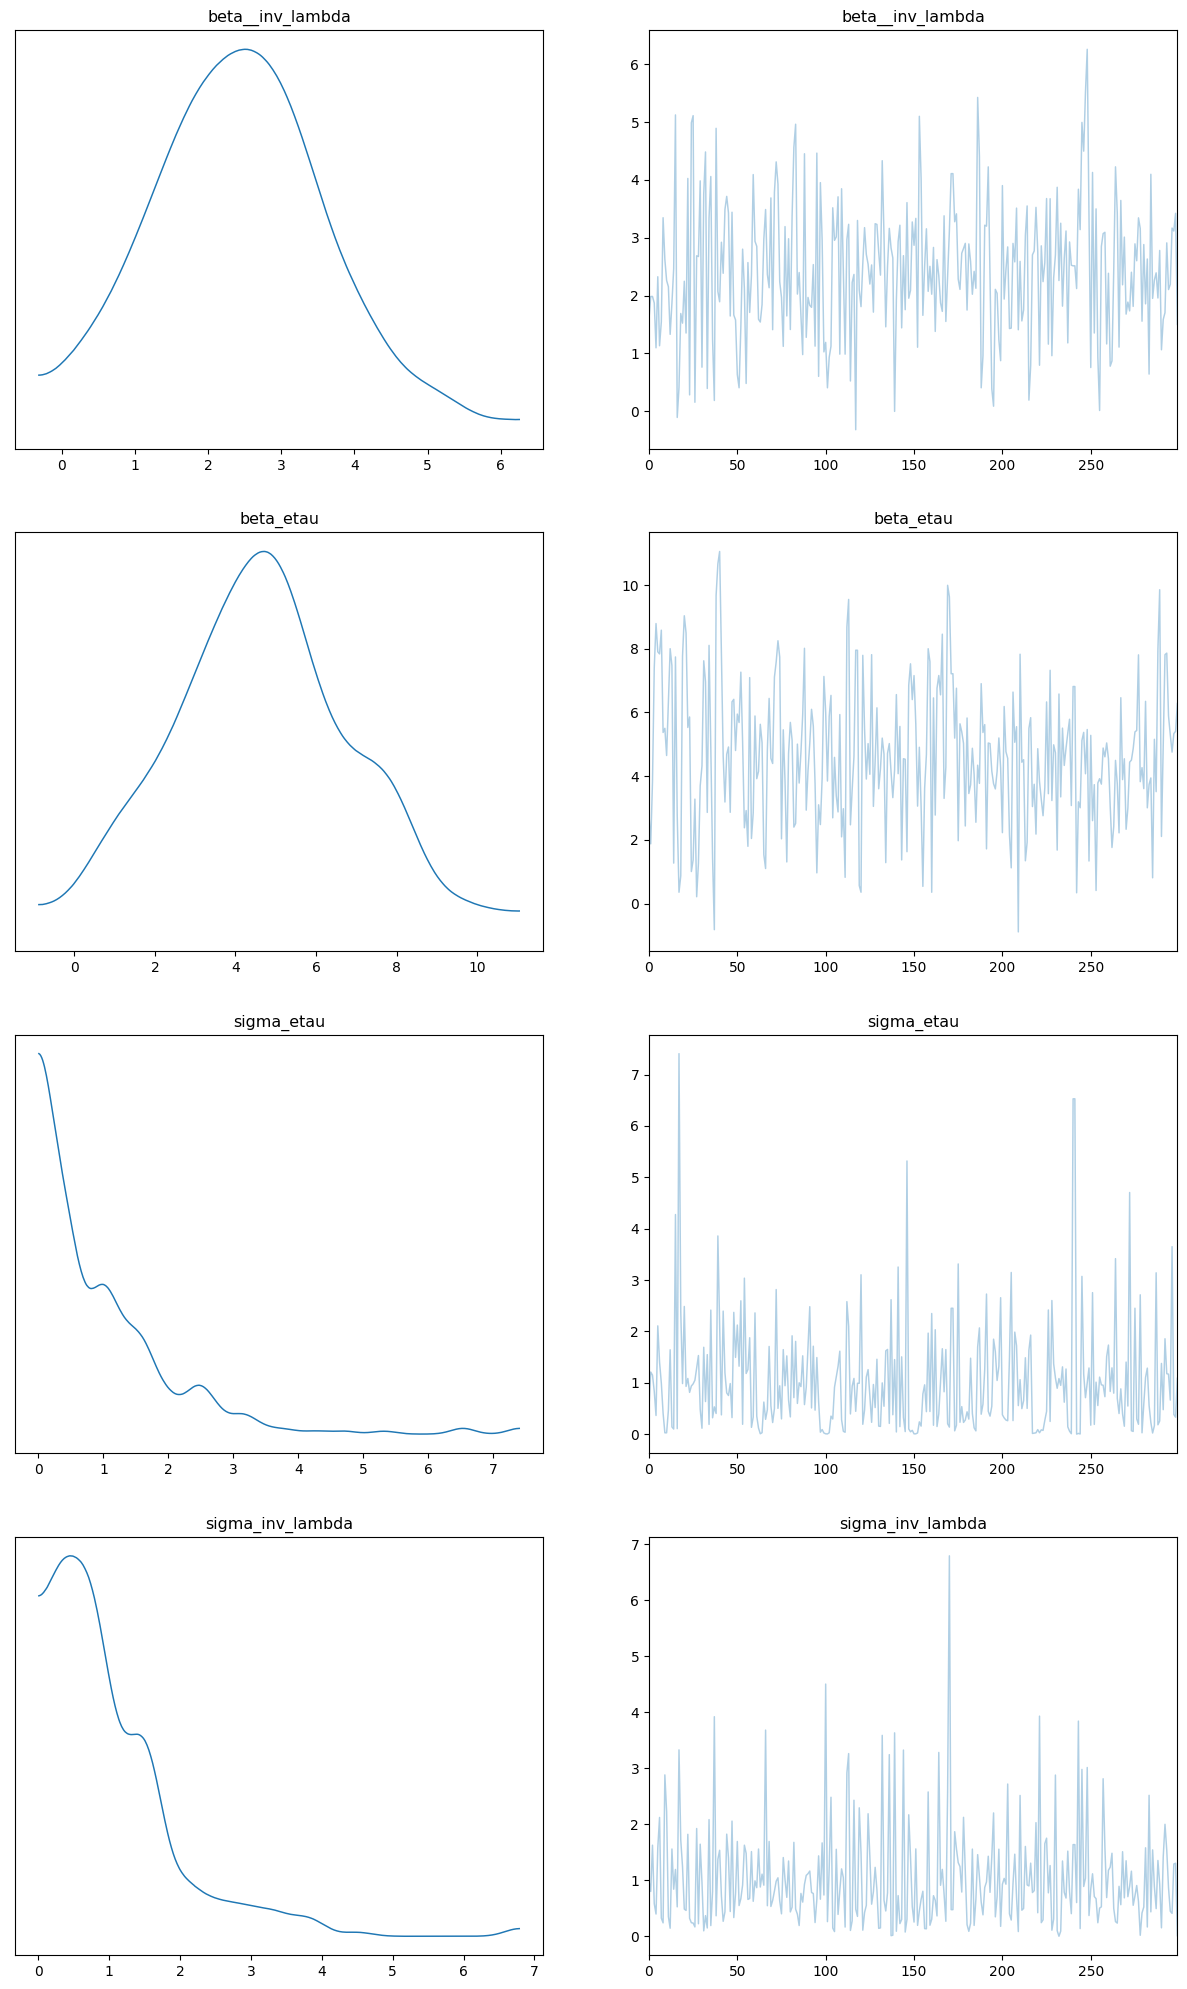

In [22]:
azdata = az.from_numpyro(mcmc)
az.plot_trace(azdata, compact=True, figsize=(15, 25));

In [ ]:
model = model
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=500, num_chains=1)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, prior_only=False, **inputs)
mcmc.print_summary(exclude_deterministic=False)

sample:  82%|████████▏ | 817/1000 [00:54<00:02, 84.00it/s, 63 steps of size 5.91e-02. acc. prob=0.92]

In [ ]:
azdata = az.from_numpyro(mcmc)
az.plot_trace(azdata, compact=True, figsize=(15, 25));
plt.tight_layout();

## Model Definition

http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.687.3554&rep=rep1&type=pdf

**Individual Customer** 

A1. *Poisson purchases*. While active, each customer makes purchases according to a Poisson process with rate λ. 

A2. *Exponential lifetime*. Each customer remains active for a lifetime, which has an exponentially distributed duration with dropout rate μ. 

**Heterogeneity across Customers** 
A3. *Individuals’ purchase rates λ and dropout rates μ follow a multivariate lognormal distribution*. Unlike a Pareto/NBD model, whereby independent gamma distributions are assumed for λ and μ, this assumption permits a correlation between purchase and dropout processes. 

There are several reasons for the lognormal assumption. 
(a) Bayesian updating of a multivariate normal (hence lognormal) is a standard procedure 
and easy to compute. The distribution can readily accommodate additional 
parameters through a hierarchical model, as will be shown in Section 2.3. 
(b) Correlation between log(λ) and log(μ) can be obtained through the 
variance-covariance matrix of the normal mixture distribution.

2.3. **Incorporating Covariates** 
A model that links purchase and dropout rates λ and μ to customer characteristics can offer insights into the profile of customers with frequent transactions and long lifetime.

 